### Thesis ADS: Rosa Lucassen

# Loading the data

In [1]:
import pickle
import pandas as pd
import numpy as np
from numpy import array

import spacy
import stop_words
nlp = spacy.load("en_core_web_sm")
nlp.vocab["covid"].is_stop = True
nlp.vocab["corona"].is_stop = True
nlp.vocab["covid19"].is_stop = True
nlp.vocab["covid-19"].is_stop = True
nlp.vocab["coronavirus"].is_stop = True

import re
import emoji
from collections import Counter
from scipy.stats import chi2_contingency
from urllib.parse import urlparse
from nltk.stem.porter import PorterStemmer

import gensim
from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim.models.wrappers import LdaMallet
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary

import logging
import pyLDAvis.gensim
import json

import warnings
warnings.filterwarnings('ignore')  # To ignore all warnings that arise here to enhance clarity
stemmer = PorterStemmer()

# Function: Cleaning data

In [2]:
def remove_single_char(text):
    single_char_pattern = r'\s+[a-zA-Z]\s+'
    without_sc = re.sub(pattern=single_char_pattern, repl=" ", string=text)
    return without_sc

def remove_numbers(text):
    number_pattern = r'\b(?<![0-9-])(\d+)(?![0-9-])'
    without_number = re.sub(pattern=number_pattern, repl=" ", string=text)
    return without_number


def remove_urls(text):
    url_pattern = r'https?://\S+|www\.\S+'
    without_urls = re.sub(pattern=url_pattern, repl=" ", string=text)
    return without_urls


def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    without_emoji = emoji_pattern.sub(r'',text)
    return without_emoji

def remove_nonalpha(text):
    nonalpha_pattern = "[+$@#?~]"
    without_nonalpha = re.sub(pattern=nonalpha_pattern, repl=" ", string=text)
    return without_nonalpha
    
def remove_rt(text):
    rt_pattern = 'rt @[\w_]+: '
    without_pattern = re.sub(pattern = rt_pattern, repl=" ", string = text)
    return without_pattern 

def remove_extra_spaces(text):
    space_pattern = r'\s+'
    without_space = re.sub(pattern=space_pattern, repl=" ", string=text)
    return without_space

def strip_list_noempty(mylist):
    newlist = (item.strip() if hasattr(item, 'strip') else item for item in mylist)
    return [item for item in newlist if item != '']

# Function: BiGrams

In [3]:
from gensim.models import Phrases
def make_n_grams(docs):
    # Add bigrams and trigrams to docs (only ones that appear 20 times or more).
    bigram = Phrases(docs, min_count=1)
    for idx in range(len(docs)):
        for token in bigram[docs[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                docs[idx].append(token)
    return docs

# Function: Lemmatizing texts

In [5]:
def pre_processer_real(corpus):
    corpus = [text.lower() for text in corpus]
    corpus = [remove_urls(text) for text in corpus]
    corpus = [remove_single_char(text) for text in corpus]
    corpus = [remove_numbers(text) for text in corpus]
    corpus = [remove_rt(text) for text in corpus]
    corpus = [remove_emojis(text) for text in corpus]
    corpus = [remove_nonalpha(text) for text in corpus]
    corpus = [text.encode("ascii", "ignore") for text in corpus]
    corpus = [text.decode() for text in corpus]
    corpus = [remove_extra_spaces(text) for text in corpus]
    corpus = strip_list_noempty(corpus)
    
    processed_texts = [text for text in nlp.pipe(corpus, 
                                              disable=["ner",
                                                       "parser"])]
    tokenized_texts = [[word.lemma_ for word in lemma_ if not word.is_punct if not word.is_stop] 
                            for lemma_ in processed_texts]
    tokenized_texts = make_n_grams(tokenized_texts)
    
    flatten = lambda t: [item for sublist in t for item in sublist]
    flat_real = flatten(tokenized_texts)
    counts = Counter(flat_real)
    total_words = sum(counts.values()) 
    for word in counts:
        counts[word] = counts[word] #* (10000) / total_words
    return counts, counts.most_common(), flat_real, tokenized_texts

def pre_processer_fake(corpus):
    corpus = [text.lower() for text in corpus]
    corpus = [remove_urls(text) for text in corpus]
    corpus = [remove_single_char(text) for text in corpus]
    corpus = [remove_numbers(text) for text in corpus]
    corpus = [remove_rt(text) for text in corpus]
    corpus = [remove_emojis(text) for text in corpus]
    corpus = [remove_nonalpha(text) for text in corpus]
    corpus = [text.encode("ascii", "ignore") for text in corpus]
    corpus = [text.decode() for text in corpus]
    corpus = [remove_extra_spaces(text) for text in corpus]
    corpus = strip_list_noempty(corpus)

    processed_texts = [text for text in nlp.pipe(corpus, 
                                              disable=["ner",
                                                       "parser"])]
    tokenized_texts = [[word.lemma_ for word in lemma_ if not word.is_punct if not word.is_stop] 
                            for lemma_ in processed_texts]
    tokenized_texts = make_n_grams(tokenized_texts)
    
    flatten = lambda t: [item for sublist in t for item in sublist]
    flat_fake = flatten(tokenized_texts)
    counts = Counter(flat_fake)
    total_words = sum(counts.values()) 
    for word in counts:
        counts[word] = counts[word] #* (10000) / total_words
    return counts, counts.most_common(), flat_fake, tokenized_texts

# Function: distinctive words

In [ ]:
def distinctive_words(target_corpus, reference_corpus):
    counts_c1 = Counter(target_corpus) # don't forget to flatten your texts!
    counts_c2 = Counter(reference_corpus)
    vocabulary = set(list(counts_c1.keys()) + list(counts_c2.keys()))
    freq_c1_total = sum(counts_c1.values()) 
    freq_c2_total = sum(counts_c2.values()) 
    results = []
    for word in vocabulary:
        freq_c1 = counts_c1[word]
        freq_c2 = counts_c2[word]
        freq_c1_other = freq_c1_total - freq_c1
        freq_c2_other = freq_c2_total - freq_c2
        llr, p_value,_,_ = chi2_contingency([[freq_c1, freq_c2], 
                      [freq_c1_other, freq_c2_other]],
                      lambda_='log-likelihood') 
        if freq_c2 / freq_c2_other > freq_c1 / freq_c1_other:
            llr = -llr
        result = {'word':word, 
                    'llr':llr,
                    'p_value': p_value}
        results.append(result)
    results_df = pd.DataFrame(results)
    return results_df

# Function: Topic modelling LDA Gensim

In [6]:
# Shows all words instead of just the 10 most popular words
def topic_modelling_results(tokenized_text, n_topics, n_iterations):
    results = []

    dictionary = Dictionary(tokenized_text) # get the vocabulary
    corpus = [dictionary.doc2bow(text) for text in tokenized_text]

    PATH_TO_MALLET = '/Users/rosalucassen/Documents/UU/DataMining/mallet-2.0.8/bin/mallet'
    N_TOPICS = n_topics
    N_ITERATIONS = n_iterations

    lda = LdaMallet(PATH_TO_MALLET,
                    corpus=corpus,
                    id2word=dictionary,
                    num_topics=N_TOPICS,
                    iterations=N_ITERATIONS)
    
    for topic in range(N_TOPICS):
        words = lda.show_topic(topic)
        topic_n_words = ' '.join([word[0] for word in words])
        result = {'Topic':str(topic), 
                    'Words':topic_n_words}
        results.append(result)
    results_DF = pd.DataFrame(results)
    pd.set_option('display.max_colwidth', None)
    return results_DF, lda, dictionary

# Function: Compute Coherence Scores

In [7]:
def compute_coherence_values(texts, start, step, limit, topn):
    dictionary = Dictionary(texts) # get the vocabulary
    dictionary.filter_extremes(no_below=5, no_above=0.5)
    corpus = [dictionary.doc2bow(text) for text in texts]

    PATH_TO_MALLET = '/Users/rosalucassen/Documents/UU/DataMining/mallet-2.0.8/bin/mallet'
    
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(PATH_TO_MALLET, corpus=corpus, num_topics=num_topics, id2word=dictionary, alpha=0.05, iterations = 100)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v', topn=topn)
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

## Exploring the data

In [7]:
d_test = pd.read_excel("/Users/rosalucassen/Desktop/Thesis/Code/Data/Constraint_English_Test2.xlsx", engine='openpyxl')
d_train = pd.read_excel("/Users/rosalucassen/Desktop/Thesis/Code/Data/Constraint_English_Train.xlsx", engine='openpyxl')
d_val = pd.read_excel("/Users/rosalucassen/Desktop/Thesis/Code/Data/Constraint_English_Val.xlsx", engine='openpyxl')
d_test_labeled = pd.read_excel("/Users/rosalucassen/Desktop/Thesis/Code/Data/english_test_with_labels.xlsx", engine='openpyxl')

#### Training data

In [ ]:
d_train.info()

In [ ]:
d_train.head()

In [ ]:
d_train["label"].unique()

In [ ]:
grouped_train = d_train.groupby('label').count() 
grouped_train.head()

#### Validation data

In [ ]:
d_val.info()

In [ ]:
d_val.head()

In [ ]:
d_val["label"].unique()

In [ ]:
grouped_val = d_val.groupby('label').count() 
grouped_val.head()

#### Test data

In [ ]:
d_test.info()

In [ ]:
d_test.head()

In [ ]:
d_test_labeled.info()

In [ ]:
d_test_labeled.head()

In [ ]:
d_test_labeled["label"].unique()

In [ ]:
grouped_test = d_test_labeled.groupby('label').count() 
grouped_test.head()

#### Combine data

In [8]:
data_train = pd.concat([d_train, d_test_labeled, d_val])
data_train.head()

id                                              tweet label
0   1  The CDC currently reports 99031 deaths. In gen...  real
1   2  States reported 1121 deaths a small rise from ...  real
2   3  Politically Correct Woman (Almost) Uses Pandem...  fake
3   4  #IndiaFightsCorona: We have 1524 #COVID testin...  real
4   5  Populous states can generate large case counts...  real

In [20]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10700 entries, 0 to 2139
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10700 non-null  int64 
 1   tweet   10700 non-null  object
 2   label   10700 non-null  object
dtypes: int64(1), object(2)
memory usage: 334.4+ KB


In [21]:
grouped_train = data_train.groupby('label').count() 
grouped_train.head()

id  tweet
label             
fake   5100   5100
real   5600   5600

## Results: Pre-processing

In [13]:
corpus_train_fake = data_train[data_train.label == "fake"]["tweet"]
corpus_train_real = data_train[data_train.label == "real"]["tweet"]
word_count_fake, output_fake, flat_fake, tokenized_texts_fake = pre_processer_fake(corpus_train_fake)
print(output_fake[:20])
word_count_real, output_real, flat_real, tokenized_texts_real = pre_processer_real(corpus_train_real)
print(output_real[:20])

[('say', 575), ('claim', 521), ('people', 507), ('virus', 441), ('vaccine', 405), ('trump', 390), ('pandemic', 368), ('case', 368), ('new', 366), ('test', 351), ('video', 327), ('india', 327), ('hospital', 319), ('death', 289), ('president', 277), ('show', 276), ('die', 271), ('cure', 266), ('lockdown', 250), ('patient', 238)]
[('case', 2963), ('test', 1811), ('report', 1481), ('new', 1463), ('state', 1371), ('number', 1057), ('death', 1044), ('total', 878), ('people', 783), ('confirm', 731), ('amp', 705), ('day', 693), ('today', 641), ('testing', 605), ('update', 577), ('indiafightscorona', 546), ('india', 501), ('health', 477), ('high', 459), ('k', 403)]


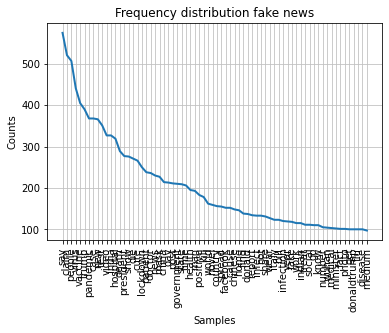

<AxesSubplot:title={'center':'Frequency distribution fake news'}, xlabel='Samples', ylabel='Counts'>

In [14]:
import nltk
from nltk import FreqDist
fdist_filtered = FreqDist(word_count_fake)
fdist_filtered.plot(70,title='Frequency distribution fake news')

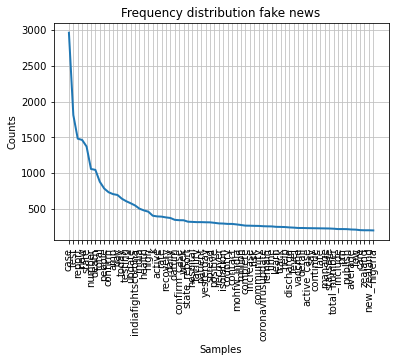

<AxesSubplot:title={'center':'Frequency distribution fake news'}, xlabel='Samples', ylabel='Counts'>

In [15]:
fdist_filtered = FreqDist(word_count_real)
fdist_filtered.plot(70,title='Frequency distribution fake news')

# Results: Optimal number of topics

In [24]:
all_scores = []
for n in range(5, 15, 1):
    model_list, coherence_values = compute_coherence_values(texts=tokenized_texts_fake, start=1, step=1, limit=12, topn=n)
    all_scores.append(coherence_values)

In [25]:
all_scores = np.array(all_scores)
avg_scores = np.average(all_scores, axis=0)

In [26]:
print(avg_scores)

[0.52098566 0.62164684 0.64927206 0.66395317 0.65513557 0.64060961
 0.65204998 0.65243579 0.64548766 0.63839602 0.63309712]


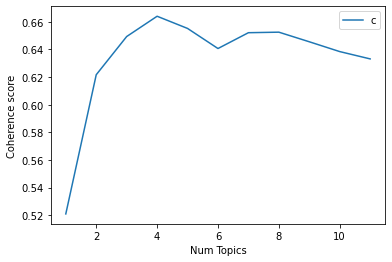

In [28]:
#Using the c_v measure
#model_list, coherence_values = compute_coherence_values(texts=tokenized_texts_fake, start=2, limit=40, step=6)
# Show graph
import matplotlib.pyplot as plt
limit=12; start=1; step=1;
x = range(start, limit, step)
plt.plot(x, avg_scores)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
all_scores = []
for n in range(5, 20, 5):
    model_list, coherence_values = compute_coherence_values(texts=tokenized_texts_real, start=1, step=1, limit=30, topn=n)
    all_scores.append(coherence_values)

In [ ]:
all_scores = np.array(all_scores)
avg_scores = np.average(all_scores, axis=0)

In [ ]:
print(avg_scores)

In [ ]:
# Show graph
import matplotlib.pyplot as plt
limit=30; start=1; step=1;
x = range(start, limit, step)
plt.plot(x, avg_scores)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

## Results: Topic modelling LDA Gensim

#### Fake news

In [29]:
topics, lda_fake, dictionary = topic_modelling_results(tokenized_texts_fake, 4, n_iterations = 1000)
topics

Topic                                                                  Words
0     0             virus case test india cure day positive kill world country
1     1     pandemic people lockdown news mask wear bill work fact donaldtrump
2     2         claim vaccine trump video death president show china post time
3     3  hospital die patient doctor government state health man people spread

#### Real news

In [23]:
topics_real, lda_real, dictionary = topic_modelling_results(tokenized_texts_real, 25, n_iterations = 1000)
topics_real

Topic  \
0      0   
1      1   
2      2   
3      3   
4      4   
5      5   
6      6   
7      7   
8      8   
9      9   
10    10   
11    11   
12    12   
13    13   
14    14   
15    15   
16    16   
17    17   
18    18   
19    19   
20    20   
21    21   
22    22   
23    23   
24    24   

                                                                                                                       Words  
0                                indiafightscorona india recovery staysafe rate indiawillwin lakh mohfw_india icmrdelhi hour  
1           case death confirm covid19nigeria case_covid19nigeria discharge discharged discharge_death akwa discharged_death  
2   covid_19 coronavirusupdate today covid__19 mohfw_india coronavirusindia covidupdate july coronaupdate covid__19_covid_19  
3                            isolation facility community manage people manage_isolation quarantine update positive auckland  
4                                  case active number total recover active_case total_number confirm_case report new_zealand  
5                              case confirm state total confirm_case nigeria discharge death total_confirm coronavirusupdate  
6                                                         amp work health support public provide plan worker response school  
7                                                               spread cdc show learn slow increase late u.s decline prevent  
8                                                  vaccine amp country drtedros ensure clinical treatment lead drtedro trial  
9                                        health world million pandemic child group year population organization report_world  
10                                                       people restriction late live england rule announce pm lockdown give  
11                                         test increase sample country update sample_test travel national september testing  
12                                            update daily state test track publish detail daily_update million state_report  
13                                      test number total complete yesterday bring date bring_total test_complete laboratory  
14                                                               mask protect stay wear amp face hand spread distancing home  
15                                                                 high day time average record continue low rate rise 7-day  
16                                                          uk government good read follow national add secretary month news  
17                                                 datum week hospitalization outbreak south long data florida current texas  
18                         day drharshvardhan woman states pib_india centre pmoindia ashwinikchoubey ddnewslive transmission  
19                                                  report death state today state_report number weekend toll low death_toll  
20                                        state number positive include large york new_york alexismadrigal change california  
21                                                           people hospital level care remain receive today person icu city  
22                                                      contact people infection close virus disease base isolate find learn  
23                                       test testing lab result capacity negative laboratory antibody testing_capacity ncdc  
24                                                        patient risk symptom study find medical severe reduce system learn

## Document topic distribution

###### Loop over documents to get topic distribution: Fake

In [ ]:
transformed_docs = lda_fake.load_document_topics()

In [ ]:
for i, document in enumerate(transformed_docs):
    print('Topic distributions for document {}'.format(i))
    for topic in document:
        print(topic)

In [ ]:
transformed_docs = lda_fake.load_document_topics()
topic_distributions_fake = pd.DataFrame([[x[1] for x in doc] for doc in transformed_docs], 
             columns=['topic_{}'.format(i) for i in range(8)])
topic_distributions_fake.tail()
topic_distributions_fake.mean().sort_values(ascending=False)

###### Loop over documents to get topic distribution: Real

In [ ]:
transformed_docs = lda_real.load_document_topics()
for i, document in enumerate(transformed_docs):
    print('Topic distributions for document {}'.format(i))
    for topic in document:
        print(topic)

In [ ]:
transformed_docs = lda_real.load_document_topics()
topic_distributions_real = pd.DataFrame([[x[1] for x in doc] for doc in transformed_docs], 
             columns=['topic_{}'.format(i) for i in range(20)])
topic_distributions_real.tail()
#topic_distributions.mean().sort_values(ascending=False)

## Find optimal number of topics using Gensim method 2

This methods takes a very long time, but will also give alpha and beta values

In [ ]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=k, alpha = a, eta = b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_texts_fake, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()
    

In [ ]:
import numpy as np
import tqdm
grid = {}

dictionary = Dictionary(tokenized_texts_real) # get the vocabulary
dictionary.filter_extremes(no_below=5, no_above=0.5)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts_real]
PATH_TO_MALLET = '/Users/rosalucassen/Documents/UU/DataMining/mallet-2.0.8/bin/mallet'

#grid['Validation_Set'] = {}
# Topics range
min_topics = 5
max_topics = 40
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
#corpus = [dictionary.doc2bow(text) for text in tokenized_texts_real]
num_of_docs = len(corpus)
#corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               #gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               #corpus]
#corpus_title = ['75% Corpus', '100% Corpus']
model_results = {#'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=270)
    
    # iterate through validation corpuses
    #for i in range(len(corpus_sets)):
        # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        for a in alpha:
            # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                cv = compute_coherence_values(corpus=corpus, dictionary=dictionary, k=k, a=a, b=b)
                # Save the model results
                #model_results['Validation_Set'].append(corpus_title[i])
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)
                    
                pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results_real.csv', index=False)
    pbar.close()

# Pre-processing emotion detection data

In [105]:
def pre_processer_real(corpus):
    #corpus = [text.lower() for text in corpus]
    corpus = [remove_urls(text) for text in corpus]
    corpus = [remove_single_char(text) for text in corpus]
    corpus = [remove_numbers(text) for text in corpus]
    corpus = [remove_rt(text) for text in corpus]
    #corpus = [remove_emojis(text) for text in corpus]
    corpus = [remove_nonalpha(text) for text in corpus]
    corpus = [text.encode("ascii", "ignore") for text in corpus]
    corpus = [text.decode() for text in corpus]
    corpus = [remove_extra_spaces(text) for text in corpus]
    corpus = strip_list_noempty(corpus)
    return corpus

def pre_processer_fake(corpus):
    #corpus = [text.lower() for text in corpus]
    corpus = [remove_urls(text) for text in corpus]
    corpus = [remove_single_char(text) for text in corpus]
    corpus = [remove_numbers(text) for text in corpus]
    corpus = [remove_rt(text) for text in corpus]
    #corpus = [remove_emojis(text) for text in corpus]
    corpus = [remove_nonalpha(text) for text in corpus]
    corpus = [text.encode("ascii", "ignore") for text in corpus]
    corpus = [text.decode() for text in corpus]
    corpus = [remove_extra_spaces(text) for text in corpus]
    corpus = strip_list_noempty(corpus)
    return corpus

In [120]:
corpus_fake = data_train[data_train.label == "fake"]["tweet"]
corpus_real = data_train[data_train.label == "real"]["tweet"]
corpus = data_train["tweet"]
corpus_fake = pre_processer_fake(corpus_fake)
print(corpus_fake)
corpus_real = pre_processer_real(corpus_real)
print(corpus_real)
corpus = pre_processer_fake(corpus)

['Politically Correct Woman (Almost) Uses Pandemic as Excuse Not to Reuse Plastic Bag coronavirus nashville', 'Obama Calls Trumps Coronavirus Response Chaotic Disaster', 'Clearly, the Obama administration did not leave any kind of game plan for something like this.', 'RetractionHydroxychloroquine or chloroquine with or without macrolide for treatment of COVID-19: multinational registry analysis - The Lancet', 'The NBA is poised to restart this month. In March we reported on how the Utah Jazz got coronavirus tests in matter of hours at time when U.S. testing was sluggish.', "Because of Donald Trump's negligence and incompetence: - More than , people have died - We have nearly million cases of COVID-19 - Over million Americans are out of work And yet hes patting himself on the back. Unbelievable.", 'Multiple Facebook posts claim that Aussies will be fined if they are found to be talking about conspiracies to do with [COVID-19]. The posts included screenshot of segment from an Australian 

Because of the amount of real data I would lose using the combined method, I won't be using that anymore. I will focus on the VADER and LIWC method. Additionally, another method will be chosen and used for comparison. 

In [57]:
count = 0
for tweet in corpus_fake:
    if (sum(len(i) for i in tweet) < 200):
        count += 1
print(count)

4234


In [58]:
count = 0
for tweet in corpus_real:
    if (sum(len(i) for i in tweet) < 200):
        count += 1
print(count)

2954


## VADER Sentiment Analysis

In [107]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/rosalucassen/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


#### Real News

In [114]:
df_real = pd.DataFrame(corpus_real)
df_real.columns = ["Tweet"]
df_real

Tweet
0     The CDC currently reports deaths. In general t...
1     States reported deaths small rise from last Tu...
2     IndiaFightsCorona: We have COVID testing labor...
3     Populous states can generate large case counts...
4     Covid Act Now found "on average each person in...
...                                                 ...
5595  NHS services could take as long as years to re...
5596  Yesterday we erroneously reported new cases in...
5597  IndiaFightsCorona: Increasing number of COVID1...
5598  Current understanding is COVID19 spreads mostl...
5599  Another new coronavirus cases have been confir...

[5600 rows x 1 columns]

In [115]:
df_real['scores'] = df_real['Tweet'].apply(lambda tweet: sid.polarity_scores(tweet))
df_real.head()

Tweet  \
0  The CDC currently reports deaths. In general t...   
1  States reported deaths small rise from last Tu...   
2  IndiaFightsCorona: We have COVID testing labor...   
3  Populous states can generate large case counts...   
4  Covid Act Now found "on average each person in...   

                                              scores  
0  {'neg': 0.238, 'neu': 0.762, 'pos': 0.0, 'comp...  
1  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  
2  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  
3  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  
4  {'neg': 0.0, 'neu': 0.936, 'pos': 0.064, 'comp...

In [116]:
df_real['compound']  = df_real['scores'].apply(lambda score_dict: score_dict['compound'])
df_real.head()

Tweet  \
0  The CDC currently reports deaths. In general t...   
1  States reported deaths small rise from last Tu...   
2  IndiaFightsCorona: We have COVID testing labor...   
3  Populous states can generate large case counts...   
4  Covid Act Now found "on average each person in...   

                                              scores  compound  
0  {'neg': 0.238, 'neu': 0.762, 'pos': 0.0, 'comp...   -0.8316  
1  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...    0.0000  
2  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...    0.0000  
3  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...    0.0000  
4  {'neg': 0.0, 'neu': 0.936, 'pos': 0.064, 'comp...    0.3818

In [117]:
# Create a function that returns desired values
# You only need to check upper bound as the next elif-statement will catch the value
def func(compound):
    if compound < -0.1:
        return "neg"
    elif compound > 0.1:
        return "pos"
    else:
        return 'neu'
df_real['Class'] = df_real['compound'].apply(func)
df_real.head()

Tweet  \
0  The CDC currently reports deaths. In general t...   
1  States reported deaths small rise from last Tu...   
2  IndiaFightsCorona: We have COVID testing labor...   
3  Populous states can generate large case counts...   
4  Covid Act Now found "on average each person in...   

                                              scores  compound Class  
0  {'neg': 0.238, 'neu': 0.762, 'pos': 0.0, 'comp...   -0.8316   neg  
1  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...    0.0000   neu  
2  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...    0.0000   neu  
3  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...    0.0000   neu  
4  {'neg': 0.0, 'neu': 0.936, 'pos': 0.064, 'comp...    0.3818   pos

In [118]:
df_real["compound"].mean()

0.07460766071428582

<AxesSubplot:ylabel='Frequency'>

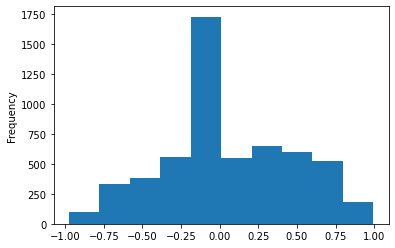

In [134]:
df_real['compound'].plot(kind = 'hist')

#### Fake News

In [128]:
df_fake = pd.DataFrame(corpus_fake)
df_fake.columns = ["Tweet"]
df_fake

Tweet
0     Politically Correct Woman (Almost) Uses Pandem...
1     Obama Calls Trumps Coronavirus Response Chaoti...
2     Clearly, the Obama administration did not leav...
3     RetractionHydroxychloroquine or chloroquine wi...
4     The NBA is poised to restart this month. In Ma...
...                                                 ...
5095                The novel coronavirus was man-made.
5096  Swine flu virus is more dangerous than the nov...
5097  Donald Trump wrongly claimed that New Zealand ...
5098  Nothing screams I am sat around doing fuck all...
5099  Birx says COVID-19 outbreak not under control ...

[5100 rows x 1 columns]

In [129]:
df_fake['scores'] = df_fake['Tweet'].apply(lambda tweet: sid.polarity_scores(tweet))
df_fake.head()

Tweet  \
0  Politically Correct Woman (Almost) Uses Pandem...   
1  Obama Calls Trumps Coronavirus Response Chaoti...   
2  Clearly, the Obama administration did not leav...   
3  RetractionHydroxychloroquine or chloroquine wi...   
4  The NBA is poised to restart this month. In Ma...   

                                              scores  
0  {'neg': 0.0, 'neu': 0.915, 'pos': 0.085, 'comp...  
1  {'neg': 0.593, 'neu': 0.407, 'pos': 0.0, 'comp...  
2  {'neg': 0.0, 'neu': 0.672, 'pos': 0.328, 'comp...  
3  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  
4  {'neg': 0.08, 'neu': 0.828, 'pos': 0.092, 'com...

In [130]:
df_fake['compound']  = df_fake['scores'].apply(lambda score_dict: score_dict['compound'])
df_fake.head()

Tweet  \
0  Politically Correct Woman (Almost) Uses Pandem...   
1  Obama Calls Trumps Coronavirus Response Chaoti...   
2  Clearly, the Obama administration did not leav...   
3  RetractionHydroxychloroquine or chloroquine wi...   
4  The NBA is poised to restart this month. In Ma...   

                                              scores  compound  
0  {'neg': 0.0, 'neu': 0.915, 'pos': 0.085, 'comp...    0.0772  
1  {'neg': 0.593, 'neu': 0.407, 'pos': 0.0, 'comp...   -0.8074  
2  {'neg': 0.0, 'neu': 0.672, 'pos': 0.328, 'comp...    0.6540  
3  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...    0.0000  
4  {'neg': 0.08, 'neu': 0.828, 'pos': 0.092, 'com...   -0.1531

In [131]:
# Create a function that returns desired values
# You only need to check upper bound as the next elif-statement will catch the value
def func(compound):
    if compound < -0.1:
        return "neg"
    elif compound > 0.1:
        return "pos"
    else:
        return 'neu'
df_fake['Class'] = df_fake['compound'].apply(func)
df_fake.head()

Tweet  \
0  Politically Correct Woman (Almost) Uses Pandem...   
1  Obama Calls Trumps Coronavirus Response Chaoti...   
2  Clearly, the Obama administration did not leav...   
3  RetractionHydroxychloroquine or chloroquine wi...   
4  The NBA is poised to restart this month. In Ma...   

                                              scores  compound Class  
0  {'neg': 0.0, 'neu': 0.915, 'pos': 0.085, 'comp...    0.0772   neu  
1  {'neg': 0.593, 'neu': 0.407, 'pos': 0.0, 'comp...   -0.8074   neg  
2  {'neg': 0.0, 'neu': 0.672, 'pos': 0.328, 'comp...    0.6540   pos  
3  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...    0.0000   neu  
4  {'neg': 0.08, 'neu': 0.828, 'pos': 0.092, 'com...   -0.1531   neg

In [132]:
df_fake["compound"].mean()

-0.06284301960784291

<AxesSubplot:ylabel='Frequency'>

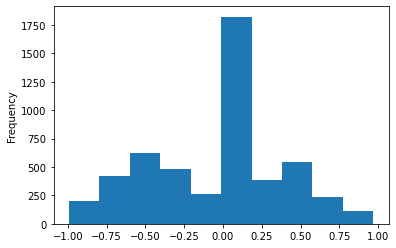

In [133]:
df_fake['compound'].plot(kind = 'hist')

#### All News

In [121]:
df = pd.DataFrame(corpus)
df.columns = ["Tweet"]
df

Tweet
0      The CDC currently reports deaths. In general t...
1      States reported deaths small rise from last Tu...
2      Politically Correct Woman (Almost) Uses Pandem...
3      IndiaFightsCorona: We have COVID testing labor...
4      Populous states can generate large case counts...
...                                                  ...
10695  Donald Trump wrongly claimed that New Zealand ...
10696  Current understanding is COVID19 spreads mostl...
10697  Nothing screams I am sat around doing fuck all...
10698  Birx says COVID-19 outbreak not under control ...
10699  Another new coronavirus cases have been confir...

[10700 rows x 1 columns]

In [122]:
df['scores'] = df['Tweet'].apply(lambda tweet: sid.polarity_scores(tweet))
df.head()

Tweet  \
0  The CDC currently reports deaths. In general t...   
1  States reported deaths small rise from last Tu...   
2  Politically Correct Woman (Almost) Uses Pandem...   
3  IndiaFightsCorona: We have COVID testing labor...   
4  Populous states can generate large case counts...   

                                              scores  
0  {'neg': 0.238, 'neu': 0.762, 'pos': 0.0, 'comp...  
1  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  
2  {'neg': 0.0, 'neu': 0.915, 'pos': 0.085, 'comp...  
3  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  
4  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...

In [123]:
df['compound']  = df['scores'].apply(lambda score_dict: score_dict['compound'])
df.head()

Tweet  \
0  The CDC currently reports deaths. In general t...   
1  States reported deaths small rise from last Tu...   
2  Politically Correct Woman (Almost) Uses Pandem...   
3  IndiaFightsCorona: We have COVID testing labor...   
4  Populous states can generate large case counts...   

                                              scores  compound  
0  {'neg': 0.238, 'neu': 0.762, 'pos': 0.0, 'comp...   -0.8316  
1  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...    0.0000  
2  {'neg': 0.0, 'neu': 0.915, 'pos': 0.085, 'comp...    0.0772  
3  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...    0.0000  
4  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...    0.0000

In [124]:
# Create a function that returns desired values
# You only need to check upper bound as the next elif-statement will catch the value
def func(compound):
    if compound < -0.1:
        return "neg"
    elif compound > 0.1:
        return "pos"
    else:
        return 'neu'
df['Class'] = df['compound'].apply(func)
df.head()

Tweet  \
0  The CDC currently reports deaths. In general t...   
1  States reported deaths small rise from last Tu...   
2  Politically Correct Woman (Almost) Uses Pandem...   
3  IndiaFightsCorona: We have COVID testing labor...   
4  Populous states can generate large case counts...   

                                              scores  compound Class  
0  {'neg': 0.238, 'neu': 0.762, 'pos': 0.0, 'comp...   -0.8316   neg  
1  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...    0.0000   neu  
2  {'neg': 0.0, 'neu': 0.915, 'pos': 0.085, 'comp...    0.0772   neu  
3  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...    0.0000   neu  
4  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...    0.0000   neu

In [125]:
df["compound"].mean()

0.009093785046728947

<AxesSubplot:ylabel='Frequency'>

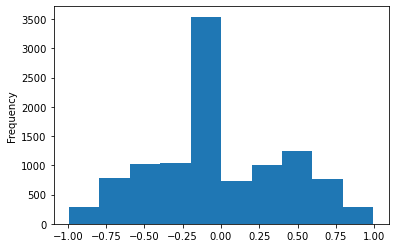

In [126]:
df['compound'].plot(kind = 'hist')

## LIWC Sentiment Analysis

#### Fake news

In [156]:
def pre_processer(corpus):
    corpus = [text.lower() for text in corpus]
    corpus = [remove_urls(text) for text in corpus]
    corpus = [remove_single_char(text) for text in corpus]
    corpus = [remove_numbers(text) for text in corpus]
    corpus = [remove_rt(text) for text in corpus]
    corpus = [remove_emojis(text) for text in corpus]
    corpus = [remove_nonalpha(text) for text in corpus]
    corpus = [text.encode("ascii", "ignore") for text in corpus]
    corpus = [text.decode() for text in corpus]
    corpus = [remove_extra_spaces(text) for text in corpus]
    corpus = strip_list_noempty(corpus)
    
    return corpus

import liwc
parse, category_names = liwc.load_token_parser('liwc.dic')

In [157]:
corpus_fake = data_train[data_train.label == "fake"]["tweet"]
corpus_real = data_train[data_train.label == "real"]["tweet"]
corpus = data_train["tweet"]
corpus_fake = pre_processer(corpus_fake)
print(corpus_fake)
corpus_real = pre_processer(corpus_real)
print(corpus_real)
corpus = pre_processer(corpus)

['politically correct woman (almost) uses pandemic as excuse not to reuse plastic bag coronavirus nashville', 'obama calls trumps coronavirus response chaotic disaster', 'clearly, the obama administration did not leave any kind of game plan for something like this.', 'retractionhydroxychloroquine or chloroquine with or without macrolide for treatment of covid-19: multinational registry analysis - the lancet', 'the nba is poised to restart this month. in march we reported on how the utah jazz got coronavirus tests in matter of hours at time when u.s. testing was sluggish.', "because of donald trump's negligence and incompetence: - more than , people have died - we have nearly million cases of covid-19 - over million americans are out of work and yet hes patting himself on the back. unbelievable.", 'multiple facebook posts claim that aussies will be fined if they are found to be talking about conspiracies to do with [covid-19]. the posts included screenshot of segment from an australian 

['the cdc currently reports deaths. in general the discrepancies in death counts between different sources are small and explicable. the death toll stands at roughly people today.', 'states reported deaths small rise from last tuesday. southern states reported of those deaths.', 'indiafightscorona: we have covid testing laboratories in india and as on th august tests have been done : profbhargava dg icmrdelhi staysafe indiawillwin', 'populous states can generate large case counts but if you look at the new cases per million today smaller states are showing more cases per million than california or texas: al ar id ks ky la ms nv and sc.', 'covid act now found "on average each person in illinois with covid-19 is infecting . other people. data shows that the infection growth rate has declined over time this factors in the stay-at-home order and other restrictions put in place."', 'if you tested positive for covid19 and have no symptoms stay home and away from other people. learn more abou

In [158]:
#from collections import Counter
feature_counts = Counter(category for token in corpus_fake for category in parse(token))
print(feature_counts)

Counter({'social': 231, 'percept': 186, 'work': 144, 'leisure': 143, 'hear': 134, 'relativ': 98, 'bio': 89, 'achieve': 82, 'humans': 61, 'space': 56, 'health': 51, 'affect': 51, 'funct': 42, 'cogmech': 40, 'see': 39, 'time': 36, 'ingest': 30, 'negemo': 26, 'posemo': 25, 'number': 23, 'relig': 22, 'home': 14, 'pronoun': 14, 'ipron': 14, 'insight': 10, 'death': 10, 'money': 10, 'inhib': 9, 'anx': 8, 'quant': 7, 'body': 7, 'certain': 7, 'cause': 6, 'feel': 6, 'motion': 6, 'tentat': 6, 'anger': 5, 'family': 5, 'sad': 5, 'sexual': 3, 'negate': 2, 'assent': 2, 'friend': 1, 'verb': 1, 'past': 1, 'excl': 1})


#### Real news

In [159]:
#from collections import Counter
feature_counts = Counter(category for token in corpus_real for category in parse(token))
print(feature_counts)

Counter({'relativ': 296, 'time': 234, 'social': 89, 'bio': 80, 'health': 72, 'funct': 69, 'work': 64, 'cogmech': 52, 'leisure': 51, 'number': 49, 'affect': 47, 'space': 45, 'humans': 35, 'death': 29, 'posemo': 25, 'achieve': 24, 'negemo': 22, 'inhib': 18, 'motion': 15, 'pronoun': 13, 'ipron': 13, 'insight': 13, 'cause': 12, 'family': 8, 'home': 7, 'anger': 6, 'ingest': 6, 'sad': 6, 'preps': 6, 'tentat': 5, 'percept': 5, 'certain': 5, 'anx': 5, 'money': 5, 'relig': 4, 'incl': 3, 'sexual': 3, 'quant': 3, 'see': 2, 'hear': 2, 'body': 2, 'excl': 1, 'feel': 1, 'assent': 1})


#### All news

In [160]:
#from collections import Counter
feature_counts = Counter(category for token in corpus for category in parse(token))
print(feature_counts)

Counter({'relativ': 394, 'social': 320, 'time': 270, 'work': 208, 'leisure': 194, 'percept': 191, 'bio': 169, 'hear': 136, 'health': 123, 'funct': 111, 'achieve': 106, 'space': 101, 'affect': 98, 'humans': 96, 'cogmech': 92, 'number': 72, 'posemo': 50, 'negemo': 48, 'see': 41, 'death': 39, 'ingest': 36, 'inhib': 27, 'pronoun': 27, 'ipron': 27, 'relig': 26, 'insight': 23, 'home': 21, 'motion': 21, 'cause': 18, 'money': 15, 'family': 13, 'anx': 13, 'certain': 12, 'tentat': 11, 'anger': 11, 'sad': 11, 'quant': 10, 'body': 9, 'feel': 7, 'sexual': 6, 'preps': 6, 'incl': 3, 'assent': 3, 'negate': 2, 'excl': 2, 'friend': 1, 'verb': 1, 'past': 1})


## Results: Most distinctive words
This gives an extreme output, why?

In [ ]:
results_df = distinctive_words(flat_real, flat_fake)
results_df.sort_values('llr', ascending=False).head(5)